In [5]:
import yaml
from provider_valid import *
import torch
from skimage.feature import hog
from attrdict import AttrDict
import time
import torch
import sys
import numpy as np
import random
sys.path.append('/code/SuperHuman-main/scripts/scripts')
from utils.show import show_one
from sklearn.metrics import f1_score

seed = 555
np.random.seed(seed)
random.seed(seed)
cfg_file = 'seg_3d.yaml'
with open('/code/SuperHuman-main/scripts/scripts/config/' + cfg_file, 'r') as f:
    cfg = AttrDict( yaml.safe_load(f) )

out_path = os.path.join('/code/SuperHuman-main/', 'data_temp')
if not os.path.exists(out_path):
    os.mkdir(out_path)

data = Provider_valid(cfg)
dataloader = torch.utils.data.DataLoader(data, batch_size=2, num_workers=0,
                                            shuffle=False, drop_last=False, pin_memory=True)

gt_affs = data.get_gt_affs()
pred = np.random.random(tuple(gt_affs.shape)).astype(np.float32)
pred[pred <= 0.5] = 0
pred[pred > 0.5] = 1
gt_affs = gt_affs.astype(np.uint8)
pred = pred.astype(np.uint8)
gt_affs = gt_affs.flatten()
pred = pred.flatten()
f1 = f1_score(1 - gt_affs, 1- pred)
print(f1)

valid on valid dataset!
the number of valid(test) = 50
load cremiC_inputs_interp.h5 ...
0.20118207407331565


In [3]:
for imgs,label,weight in dataloader:
    print(imgs.shape)
    print(label.shape)
    print(weight.shape)
    break

torch.Size([2, 1, 32, 160, 160])
torch.Size([2, 3, 32, 160, 160])
torch.Size([2, 3, 32, 160, 160])


In [66]:
img_hog =hog(imgs[0,0,0], orientations=9, pixels_per_cell=(8, 8), cells_per_block=(1, 1), block_norm='L2', feature_vector=False)

In [68]:
img_hog.shape

(20, 20, 1, 1, 9)

In [60]:
imgs[0,0,0]

tensor([[0.4863, 0.5255, 0.5333,  ..., 0.4863, 0.5020, 0.5569],
        [0.5686, 0.5804, 0.6196,  ..., 0.5098, 0.5686, 0.5882],
        [0.5922, 0.6235, 0.6745,  ..., 0.5255, 0.5725, 0.5725],
        ...,
        [0.6863, 0.6667, 0.6157,  ..., 0.6235, 0.6235, 0.4980],
        [0.6627, 0.6510, 0.6353,  ..., 0.6471, 0.5961, 0.3412],
        [0.6510, 0.6353, 0.6510,  ..., 0.6471, 0.4431, 0.1569]])

In [52]:
from matplotlib import pyplot as plt

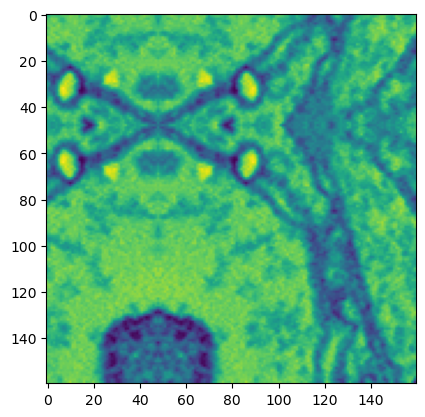

In [54]:
plt.imshow(imgs[0,0,0])

In [36]:
import numpy as np
import math
from scipy.ndimage import convolve
from tqdm import tqdm


def hog3d(vox_volume, cell_size, block_size, theta_histogram_bins, phi_histogram_bins, step_size=None):
    """
    Inputs
    vox_volume : a 	[x x y x z] numpy array defining voxels with values in the range 0-1
    cell_size : size of a 3d cell (int)
    block_size : size of a 3d block defined in cells
    theta_histogram_bins : number of bins to break the angles in the xy plane - 180 degrees
    phi_histogram_bins : number of bins to break the angles in the xz plane - 360 degrees
    step_size : OPTIONAL integer defining the number of cells the blocks should overlap by.
	"""

    if step_size is None:
        step_size = block_size

    c = cell_size
    b = block_size

    sx, sy, sz = vox_volume.shape

    num_x_cells = math.floor(sx / cell_size)
    num_y_cells = math.floor(sy / cell_size)
    num_z_cells = math.floor(sz / cell_size)

    # Get cell positions
    x_cell_positions = np.array(list(range(0, (num_x_cells * cell_size), cell_size)))
    y_cell_positions = np.array(list(range(0, (num_y_cells * cell_size), cell_size)))
    z_cell_positions = np.array(list(range(0, (num_z_cells * cell_size), cell_size)))

    # Get block positions
    x_block_positions = (x_cell_positions[0: num_x_cells: block_size])
    y_block_positions = (y_cell_positions[0: num_y_cells: block_size])
    z_block_positions = (z_cell_positions[0: num_z_cells: block_size])

    # Check if last block in each dimension has enough voxels to be a full block. If not, discard it.
    if x_block_positions[-1] > ((sx + 1) - (cell_size * block_size)):
        x_block_positions = x_block_positions[:-2]
    if y_block_positions[-1] > ((sy + 1) - (cell_size * block_size)):
        y_block_positions = y_block_positions[:-2]
    if z_block_positions[-1] > ((sz + 1) - (cell_size * block_size)):
        z_block_positions = z_block_positions[:-2]

    # Number of blocks
    num_x_blocks = len(x_block_positions)
    num_y_blocks = len(y_block_positions)
    num_z_blocks = len(z_block_positions)

    # Create 3D gradient vectors
    # X filter and vector
    x_filter = np.zeros((3, 3, 3))
    x_filter[0, 1, 1], x_filter[2, 1, 1] = 1, -1
    x_vector = convolve(vox_volume, x_filter, mode='constant', cval=0)

    # Y filter and vector
    y_filter = np.zeros((3, 3, 3))
    y_filter[1, 0, 0], y_filter[1, 2, 0] = 1, -1
    y_vector = convolve(vox_volume, y_filter, mode='constant', cval=0)

    # Z filter and vector
    z_filter = np.zeros((3, 3, 3))
    z_filter[1, 1, 0], z_filter[1, 1, 2] = 1, -1
    z_vector = convolve(vox_volume, z_filter, mode='constant', cval=0)

    magnitudes = np.zeros([sx, sy, sz])
    for i in range(sx):
        for j in range(sy):
            for k in range(sz):
                magnitudes[i, j, k] = (x_vector[i, j, k] ** 2 + y_vector[i, j, k] ** 2 + z_vector[i, j, k] ** 2) ** (
                    0.5)

    # Voxel Weights
    kernel_size = 3
    voxel_filter = np.full((kernel_size, kernel_size, kernel_size), 1 / (kernel_size * kernel_size * kernel_size))
    weights = convolve(vox_volume, voxel_filter, mode='constant', cval=0)
    weights = weights + 1

    # Gradient vector
    grad_vector = np.zeros((sx, sy, sz, 3))
    for i in range(sx):
        for j in range(sy):
            for k in range(sz):
                grad_vector[i, j, k, 0] = x_vector[i, j, k]
                grad_vector[i, j, k, 1] = y_vector[i, j, k]
                grad_vector[i, j, k, 2] = z_vector[i, j, k]

    theta = np.zeros((sx, sy, sz))
    phi = np.zeros((sx, sy, sz))
    for i in range(sx):
        for j in range(sy):
            for k in range(sz):
                theta[i, j, k] = math.acos(grad_vector[i, j, k, 2])
                phi[i, j, k] = math.atan2(grad_vector[i, j, k, 1], grad_vector[i, j, k, 0])
                phi[i, j, k] += math.pi

    # Binning
    b_size_voxels = int(c * b)
    t_hist_bins = math.pi / theta_histogram_bins
    p_hist_bins = (2 * math.pi) / phi_histogram_bins

    block_inds = np.zeros((num_x_blocks * num_y_blocks * num_z_blocks, 3))
    i = 0
    for z_block in range(num_z_blocks):
        for y_block in range(num_y_blocks):
            for x_block in range(num_x_blocks):
                block_inds[i] = np.array(
                    [x_block_positions[x_block], y_block_positions[y_block], z_block_positions[z_block]])
                i += 1

    num_blocks = len(block_inds)
    error_count = 0
    features = []
    for i in range(num_blocks):
        full_empty = vox_volume[int(block_inds[i, 0]):int(block_inds[i, 0] + b_size_voxels),
                     int(block_inds[i, 1]):int(block_inds[i, 1] + b_size_voxels),
                     int(block_inds[i, 2]):int(block_inds[i, 2] + b_size_voxels)]

        if np.sum(full_empty) != 0 and np.sum(full_empty) != full_empty.size:
            feature = np.zeros((b, b, b, theta_histogram_bins, phi_histogram_bins))
            t_weights = weights[int(block_inds[i, 0]):int(block_inds[i, 0] + b_size_voxels),
                        int(block_inds[i, 1]):int(block_inds[i, 1] + b_size_voxels),
                        int(block_inds[i, 2]):int(block_inds[i, 2] + b_size_voxels)]
            t_magnitudes = magnitudes[int(block_inds[i, 0]):int(block_inds[i, 0] + b_size_voxels),
                           int(block_inds[i, 1]):int(block_inds[i, 1] + b_size_voxels),
                           int(block_inds[i, 2]):int(block_inds[i, 2] + b_size_voxels)]
            t_theta = theta[int(block_inds[i, 0]):int(block_inds[i, 0] + b_size_voxels),
                      int(block_inds[i, 1]):int(block_inds[i, 1] + b_size_voxels),
                      int(block_inds[i, 2]):int(block_inds[i, 2] + b_size_voxels)]
            t_phi = phi[int(block_inds[i, 0]):int(block_inds[i, 0] + b_size_voxels),
                    int(block_inds[i, 1]):int(block_inds[i, 1] + b_size_voxels),
                    int(block_inds[i, 2]):int(block_inds[i, 2] + b_size_voxels)]

            for l in range(b_size_voxels):
                for m in range(b_size_voxels):
                    for n in range(b_size_voxels):
                        cell_pos_x = math.ceil(l / c) - 1
                        cell_pos_y = math.ceil(m / c) - 1
                        cell_pos_z = math.ceil(n / c) - 1

                        hist_pos_theta = math.ceil(t_theta[l, m, n] / t_hist_bins) - 1
                        hist_pos_phi = math.ceil(t_phi[l, m, n] / p_hist_bins) - 1

                        if phi_histogram_bins >= hist_pos_phi > 0 and theta_histogram_bins >= hist_pos_theta > 0:
                            feature[cell_pos_x, cell_pos_y, cell_pos_z, hist_pos_theta, hist_pos_phi] += (
                                    t_magnitudes[l, m, n] * t_weights[l, m, n])
                        else:
                            error_count += 1

            feature = np.reshape(feature, ((b * b * b), theta_histogram_bins, phi_histogram_bins))
            l2 = np.linalg.norm(feature)
            if l2 != 0:
                norm_feature = feature / l2
            else:
                norm_feature = feature
            norm_feature = np.reshape(norm_feature, ((b * b * b), (theta_histogram_bins * phi_histogram_bins)))

            features.append(norm_feature)

    features = np.array(features)

    return features


In [62]:
grad_vec.shape

(19683, 27, 25)

In [41]:
vox_volume = np.full((256,256,256),0.5)
cell_size = 3
block_size = 3
theta_histogram_bins = 5
phi_histogram_bins = 5
grad_vec = hog3d(vox_volume, cell_size, block_size, theta_histogram_bins, phi_histogram_bins)
print("Test 2 : ", grad_vec)

Test 2 :  [[[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 ...

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]]


In [4]:
import torch.nn.functional as F
import torch.nn as nn
loss = F.binary_cross_entropy

In [5]:
label.shape

torch.Size([2, 3, 32, 160, 160])

In [6]:
x = torch.randn(2,3,32,160,160)
loss(torch.sigmoid(x),label,weight)

tensor(1.4206)

In [7]:
for i in dataloader:
    print(i[0].shape,i[1].shape)
    break

torch.Size([2, 1, 32, 160, 160]) torch.Size([2, 3, 32, 160, 160])


In [8]:
!nvidia-smi

Tue Jan  3 13:33:40 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.63.01    Driver Version: 470.63.01    CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  Off  | 00000000:60:00.0 Off |                  N/A |
| 25%   31C    P2    54W / 250W |    437MiB / 11178MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

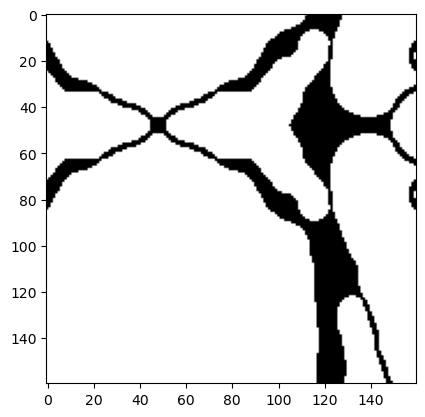

In [9]:
from matplotlib import pyplot as plt
plt.imshow(i[1][0,0,0,:,:],cmap = 'gray')

In [10]:
torch.min(i[0])

tensor(0.)

In [11]:
len(dataloader)

423

In [12]:
inputs, target, wrightmap = i

In [13]:
data.out_affs.shape

(3, 58, 1120, 1120)

In [14]:
data.get_gt_affs().shape

(3, 50, 1024, 1024)

In [15]:
data.get_gt_affs()[:, -1, ...].shape

(3, 1024, 1024)

In [16]:
data.dataset[0].shape

(58, 1120, 1120)

In [17]:
state = torch.load('/data/cyd0806/superhuman/models/superhuman_1228/2022-12-27--03-50-55_seg_3d/model-168000.pt')

In [18]:
state.keys()

dict_keys(['current_iter', 'valid_result', 'model_weights'])

In [19]:
from model.unetr import UNETR
from model.model_superhuman import UNet_PNI

In [20]:
superhuman = UNet_PNI(in_planes=cfg.MODEL.input_nc,
                        out_planes=cfg.MODEL.output_nc,
                        filters=cfg.MODEL.filters,
                        upsample_mode=cfg.MODEL.upsample_mode,
                        decode_ratio=cfg.MODEL.decode_ratio,
                        merge_mode=cfg.MODEL.merge_mode,
                        pad_mode=cfg.MODEL.pad_mode,
                        bn_mode=cfg.MODEL.bn_mode,
                        relu_mode=cfg.MODEL.relu_mode,
                        init_mode=cfg.MODEL.init_mode)

In [21]:
superhuman_state = torch.load('/data/cyd0806/superhuman/models/superhuman/2022-12-21--12-53-47_seg_3d/model-088000.pt')['model_weights']

In [22]:
superhuman_new = {}
for k, v in superhuman_state.items():
    superhuman_new[k[7:]] = v

In [23]:
superhuman.load_state_dict(superhuman_new)

<All keys matched successfully>

In [24]:
superhuman = superhuman.cuda()
superhuman_pred = superhuman(imgs.cuda())

In [25]:
superhuman_pred.shape

torch.Size([2, 3, 32, 160, 160])

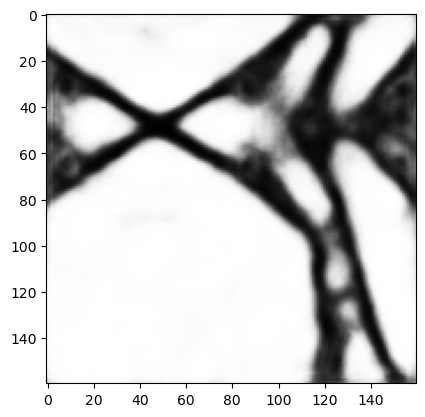

In [26]:
from matplotlib import pyplot as plt
plt.imshow(superhuman_pred[0,0,0,:,:].cpu().detach().numpy(),cmap = 'gray')

In [27]:
import waterz
from utils.lmc import mc_baseline
from utils.fragment import watershed, randomlabel
sf = 'OneMinus<HistogramQuantileAffinity<RegionGraphType, 50, ScoreValue, 256>>'
truth = data.get_gt_affs()[:3]
fragments = watershed(truth, 'maxima_distance')
seg_waterz = list(waterz.agglomerate(truth, [0.50],
                                                            fragments=fragments,
                                                            scoring_function=sf,
                                                            discretize_queue=256))[0]

Compiling waterz in /root/.cython/inline


/opt/conda/lib/python3.7/site-packages/Cython/Compiler/Main.py:369: FutureWarning: Cython directive 'language_level' not set, using 2 for now (Py2). This will change in a later release! File: /root/.cython/inline/waterz_1dd8d62f7060585ef98d31c0e427c316.pyx
  tree = Parsing.p_module(s, pxd, full_module_name)


Preparing segmentation volume...
counting regions and sizes...
creating region graph for 180106 nodes
creating statistics provider
extracting region graph...
Region graph number of edges: 1317219
merging until threshold 0.5
computing initial scores
merging until 0.5
min edge score 0.00195312
threshold exceeded
merged 179758 edges
extracting segmentation


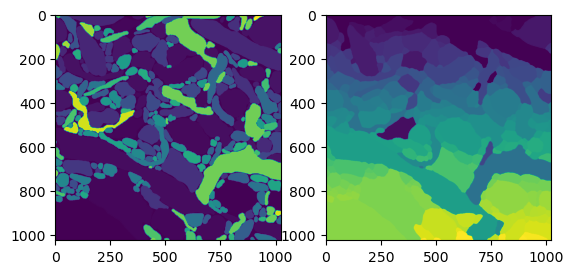

In [28]:
from matplotlib import pyplot as plt
plt.subplot(1, 2, 1)
plt.imshow(data.get_gt_lb()[0])
plt.subplot(1, 2, 2)
plt.imshow(seg_waterz[0])

In [29]:
from utils.show import show_affs, show_affs_whole
from loss.loss import WeightedMSE, WeightedBCE
from loss.loss import MSELoss, BCELoss


In [30]:
superhuman_pred[0,0,0,100:,:40].data.numpy()

TypeError: can't convert cuda:0 device type tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory first.

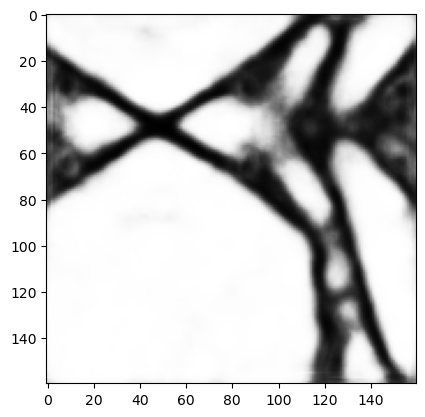

In [ ]:
plt.imshow(superhuman_pred[0,0,0].data.numpy(),cmap='gray')

In [ ]:
model = UNETR(
                        in_channels=cfg.MODEL.input_nc,
                        out_channels=cfg.MODEL.output_nc,
                        img_size=cfg.MODEL.unetr_size,
                        patch_size=cfg.MODEL.patch_size,
                        kernel_size=cfg.MODEL.kernel_size,
                        feature_size=16,
                        hidden_size=768, # 768
                        mlp_dim=3072,  # 3072
                        num_heads=12,  # 12
                        pos_embed='perceptron',
                        norm_name='instance',
                        conv_block=True,
                        res_block=True,
                        dropout_rate=0.0).cuda()


In [ ]:
unetr_state = torch.load('/data/cyd0806/superhuman/models/UNETR32*160*160_patch4*16*16_kernel133_pretrainMAE_0.65/2023-01-01--15-43-49_seg_3d/model-069000.pt')['model_weights']

In [ ]:
new_state = {}
for k, v in unetr_state.items():
    new_state[k.replace('module.', '')] = v


In [ ]:
model.load_state_dict(new_state)

<All keys matched successfully>

In [ ]:
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
model = model.to(device)
unetr_pred = model(imgs.to(device))

In [ ]:
unetr_pred.max()

tensor(1.6822, device='cuda:1', grad_fn=<MaxBackward1>)

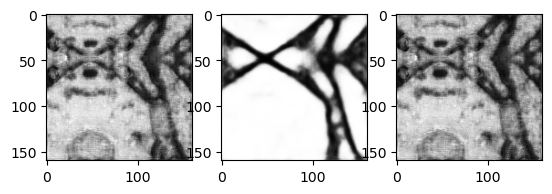

In [ ]:
plt.subplot(1,3,1)
plt.imshow(torch.sigmoid(unetr_pred[0,0,0]).data.cpu().numpy(),cmap='gray')
plt.subplot(1,3,2)
plt.imshow(superhuman_pred[0,0,0].data.cpu().numpy(),cmap='gray')
plt.subplot(1,3,3)
plt.imshow(unetr_pred[0,0,0].data.cpu().numpy(),cmap='gray')

In [ ]:
del model
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = UNet_PNI(in_planes=cfg.MODEL.input_nc,
                        out_planes=cfg.MODEL.output_nc,
                        filters=cfg.MODEL.filters,
                        upsample_mode=cfg.MODEL.upsample_mode,
                        decode_ratio=cfg.MODEL.decode_ratio,
                        merge_mode=cfg.MODEL.merge_mode,
                        pad_mode=cfg.MODEL.pad_mode,
                        bn_mode=cfg.MODEL.bn_mode,
                        relu_mode=cfg.MODEL.relu_mode,
                        init_mode=cfg.MODEL.init_mode).to(device)


In [ ]:
model = model.cpu()
pred = model(imgs)

In [ ]:
pred.max()

tensor(0.9996, grad_fn=<MaxBackward1>)

In [ ]:
from utils.show import show_affs, show_affs_whole
from loss.loss import WeightedMSE, WeightedBCE
from loss.loss import MSELoss, BCELoss
from tqdm import tqdm 
criterion = WeightedMSE()
iters = 1
if cfg.TRAIN.if_valid:
    if iters % cfg.TRAIN.save_freq == 0 or iters == 1:
        device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
        model = model.to(device)
        model.eval()
        dataloader = torch.utils.data.DataLoader(data, batch_size=1, num_workers=0,
                                        shuffle=False, drop_last=False, pin_memory=True)
        losses_valid = []
        #记录开始时间
        start = time.time()
        for k, batch in tqdm(enumerate(dataloader, 0)):
            inputs, target, weightmap = batch
            inputs = inputs.to(device)
            target = target.to(device)
            weightmap = weightmap.to(device)
            with torch.no_grad():
                pred = model(inputs)
            tmp_loss = criterion(pred, target, weightmap)
            losses_valid.append(tmp_loss.item())
            data.add_vol(np.squeeze(pred.data.cpu().numpy()))
        #记录结束时间
        end = time.time()
        
        epoch_loss = sum(losses_valid) / len(losses_valid)
        out_affs = data.get_results()
        gt_affs = data.get_gt_affs().copy()
        gt_seg = data.get_gt_lb()
        data.reset_output()
        out_affs = out_affs[:3]
        # gt_affs = gt_affs[:, :3]
        show_affs_whole(iters, out_affs, gt_affs, '/code/SuperHuman-main/data_temp')

845it [03:48,  3.70it/s]


In [ ]:
import torch.nn.functional as F
criterion = WeightedBCE()


In [ ]:

criterion(pred.cpu(), torch.tensor(target).cpu())

RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call,so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.

In [ ]:
input = torch.randn(1,1,32,160,160, requires_grad=False)
target = torch.rand(1,1,32,160,160, requires_grad=False)
loss = F.binary_cross_entropy(torch.sigmoid(input), target)

In [ ]:
target.shape

torch.Size([1, 1, 32, 160, 160])

In [ ]:
target

tensor([[[[[0.7447, 0.8484, 0.3321,  ..., 0.8043, 0.8035, 0.7476],
           [0.9515, 0.7561, 0.8983,  ..., 0.8295, 0.6940, 0.6711],
           [0.8419, 0.5474, 0.6477,  ..., 0.4473, 0.8594, 0.6714],
           ...,
           [0.8291, 0.4645, 0.3407,  ..., 0.2821, 0.1743, 0.6818],
           [0.5067, 0.4543, 0.0269,  ..., 0.6478, 0.4378, 0.2083],
           [0.3828, 0.1041, 0.2098,  ..., 0.7481, 0.2704, 0.4692]],

          [[0.7498, 0.2028, 0.5126,  ..., 0.9640, 0.9369, 0.7371],
           [0.4337, 0.4374, 0.9139,  ..., 0.0068, 0.9510, 0.0465],
           [0.4829, 0.7460, 0.9764,  ..., 0.6797, 0.2759, 0.8500],
           ...,
           [0.3882, 0.2223, 0.8100,  ..., 0.6611, 0.7037, 0.5304],
           [0.6664, 0.8197, 0.8455,  ..., 0.0093, 0.0820, 0.1425],
           [0.1343, 0.2097, 0.2239,  ..., 0.3985, 0.6040, 0.5091]],

          [[0.3229, 0.4871, 0.6016,  ..., 0.1130, 0.2220, 0.6290],
           [0.8256, 0.8672, 0.6773,  ..., 0.9227, 0.9454, 0.3409],
           [0.4275, 0.8145

In [ ]:
input

tensor([[-0.1148, -0.9856],
        [-0.4929, -1.0999],
        [-0.8331,  1.1626]])

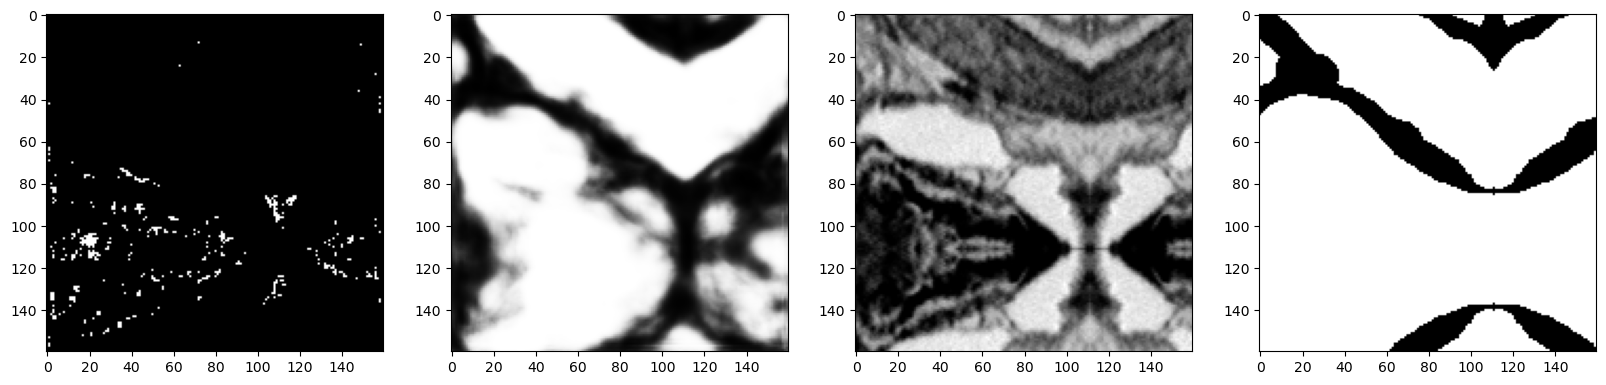

In [ ]:
plt.figure(figsize = (20,5))
pred[pred < 0.5] = 0
pred[pred > 0.5] = 1
plt.subplot(1,4,1)
plt.imshow(pred[0,0,20].cpu().data.numpy(),cmap='gray')
plt.subplot(1,4,2)
plt.imshow(superhuman_pred[0,0,20].cpu().data.numpy(),cmap='gray')
plt.subplot(1,4,3)
plt.imshow(inputs[0,0,20].cpu().data.numpy(),cmap='gray')
plt.subplot(1,4,4)
plt.imshow(target[0,0,20].cpu().data.numpy(),cmap='gray')


In [ ]:
gt_affs = data.get_gt_affs()
pred = np.random.random(tuple(gt_affs.shape)).astype(np.float32)

In [ ]:
data.crop_size[0]

32

In [ ]:
np.meshgrid(np.linspace(-1, 1, data.out_size[0], dtype=np.float32),
                                    np.linspace(-1, 1, data.out_size[1], dtype=np.float32),
                                    np.linspace(-1, 1, data.out_size[2], dtype=np.float32), indexing='ij')[2].shape

(32, 160, 160)

In [ ]:
i[2].shape

torch.Size([1, 3, 32, 160, 160])

In [ ]:
data.get_gt_affs().shape

(3, 50, 1024, 1024)

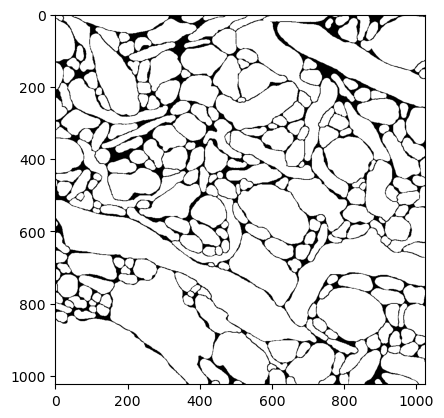

In [ ]:
from matplotlib import pyplot as plt
plt.imshow(data.get_gt_affs()[0,0,:,:],cmap='gray')

In [ ]:
data.get_gt_lb().shape

(50, 1024, 1024)

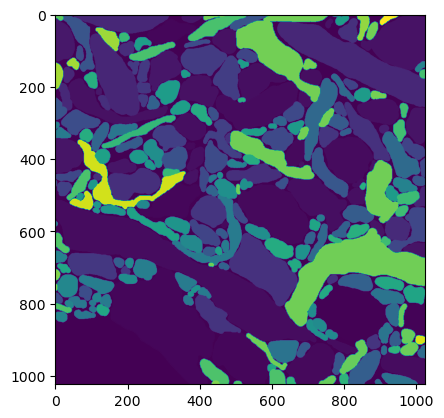

In [ ]:
plt.imshow(data.get_gt_lb()[0,:,:])

In [ ]:
len(data[0])

3